In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import phik
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
glass_df = pd.read_csv("glass.csv")
glass_df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


### EDA

In [3]:
glass_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [4]:
print(f"Dataset shape: {glass_df.shape}")

Dataset shape: (214, 10)


In [5]:
glass_df["Type"].value_counts().sort_values()

Type
6     9
5    13
3    17
7    29
1    70
2    76
Name: count, dtype: int64

In [6]:
glass_df.isna().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

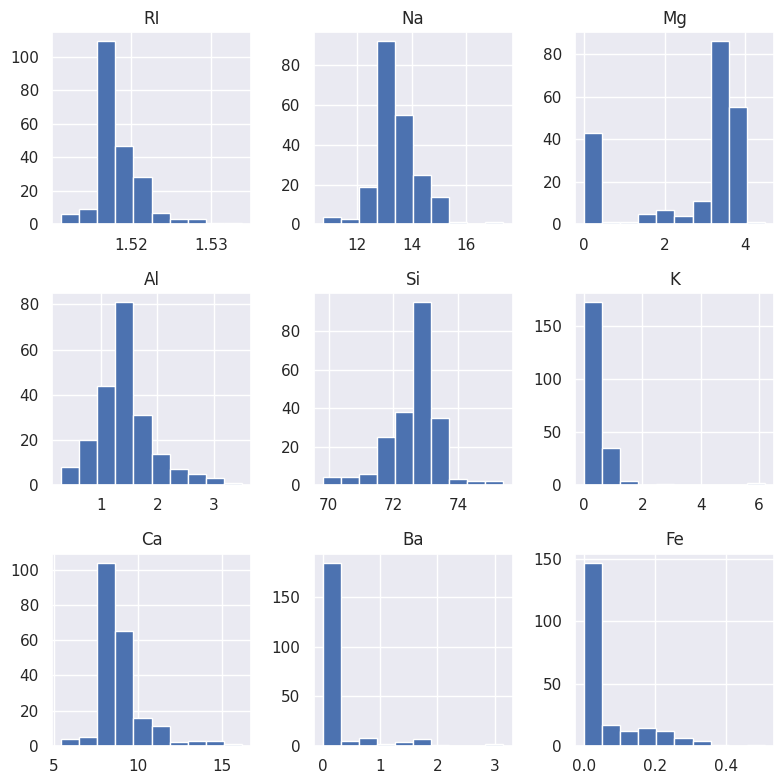

In [7]:
sns.set_theme()
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
glass_df.drop(columns="Type").hist(ax=axs)
plt.tight_layout()
plt.show()

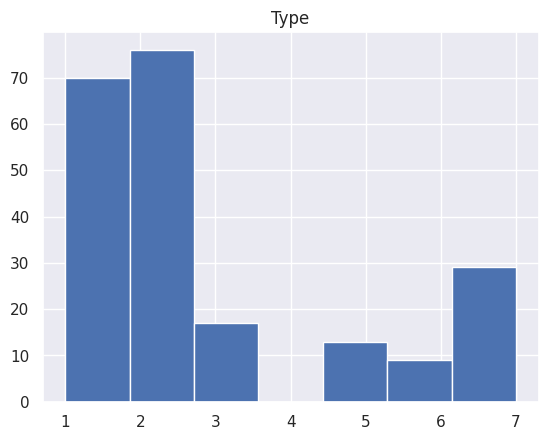

In [8]:
plt.title("Type")
glass_df["Type"].hist(bins=7)
plt.show()

<Figure size 1200x1000 with 0 Axes>

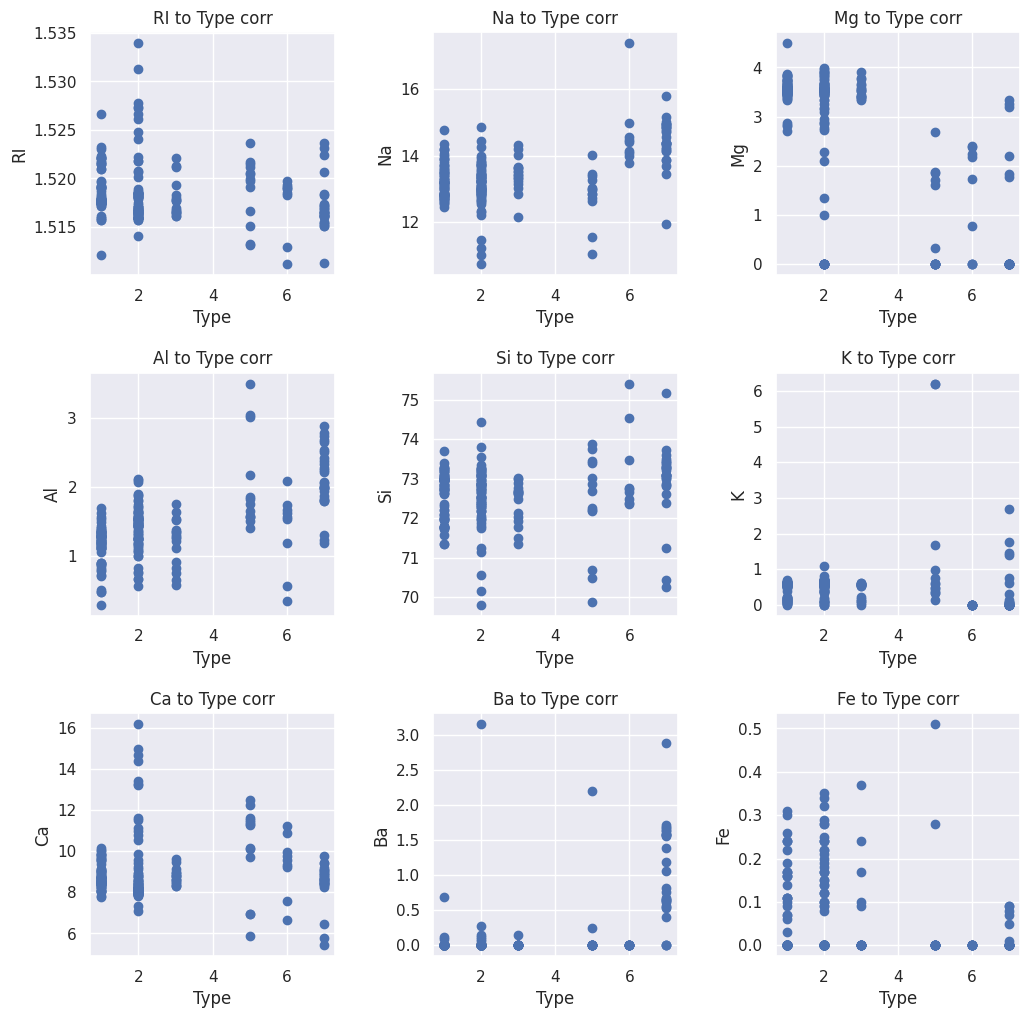

In [49]:
plt.figure(figsize=(12, 10))
fig, axs = plt.subplots(3, 3, figsize=(12, 12), gridspec_kw={"wspace": 0.4, "hspace": 0.4}) 
columns = list(glass_df)[:-1]
for idx, ax in enumerate(axs.flat):
    ax.scatter(x=glass_df["Type"], y = glass_df[columns[idx]])
    ax.set_title(f"{columns[idx]} to Type corr")
    ax.set_xlabel("Type")
    ax.set_ylabel(f"{columns[idx]}")
plt.show()

interval columns not set, guessing: ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']


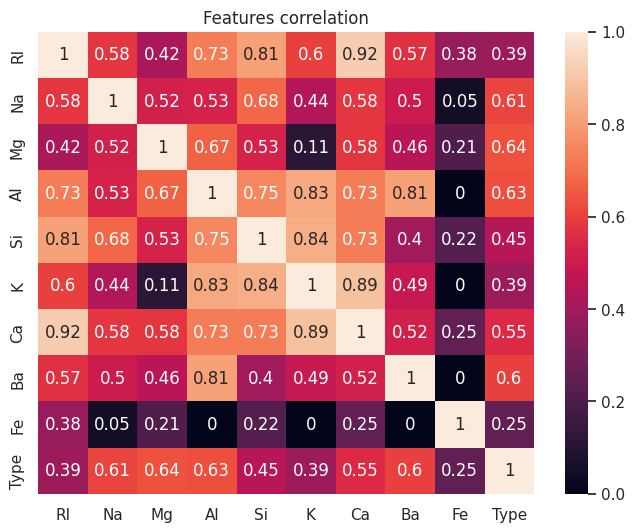

In [9]:
plt.figure(figsize=(8, 6))
plt.title("Features correlation")
sns.heatmap(glass_df.phik_matrix().round(2), annot=True)
plt.show()

Признак Fe слабо коррелируют с целевой переменной, можно его не брать в обучающую выборку

In [10]:
X = glass_df[['RI', 'Na', 'Mg', 'Al', 'Si', 'Ca', 'Ba']]
y = glass_df["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Подбор лучших параметров

In [11]:
rf_clf = RandomForestClassifier()
params = {
    "max_depth": range(5, 11),
    "min_samples_split": range(20, 71, 5),
    "min_samples_leaf":  range(20, 71, 5),
    "max_features": range(len(list(glass_df)[:-1]))
}

In [33]:
gscv = GridSearchCV(estimator=rf_clf, param_grid=params, cv=5)
gscv.fit(X_train, y_train)
gscv.best_params_   

{'max_depth': 9,
 'max_features': 3,
 'min_samples_leaf': 20,
 'min_samples_split': 20}

### Обучение модели

In [12]:
rf_clf = make_pipeline( 
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=100,
        criterion="entropy",
        max_depth=5,
        min_samples_split=30,
        min_samples_leaf=10,
        max_features=3,
        max_samples=0.63,
        random_state=0
    )
)       
rf_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=5,
                                        max_features=3, max_samples=0.63,
                                        min_samples_leaf=10,
                                        min_samples_split=30,
                                        random_state=0))])

In [13]:
y_pred = rf_clf.predict(X_test)
print(f"Score: {rf_clf.score(X_test, y_test)}")
print(f"Accuracy: {accuracy_score(y_pred, y_test)}")

Score: 0.5116279069767442
Accuracy: 0.5116279069767442


### Удаление выбросов и обучение модели 

In [60]:
clean_df = glass_df.copy()
print(f"Было {clean_df.shape[0]} записи,", end=" ")
clean_df = clean_df.query("7<Ca<11")
clean_df = clean_df.query("Ba<0.05")
clean_df = clean_df.query("1.515<RI<1.530")
clean_df = clean_df.query("71<Si<74")
# clean_df = clean_df.query("3<Mg<4.3")
print(f"cтало {clean_df.shape[0]}. Потерянный процент данных: {round(100-150*100/214)}%")

Было 214 записи, cтало 150. Потерянный процент данных: 30%


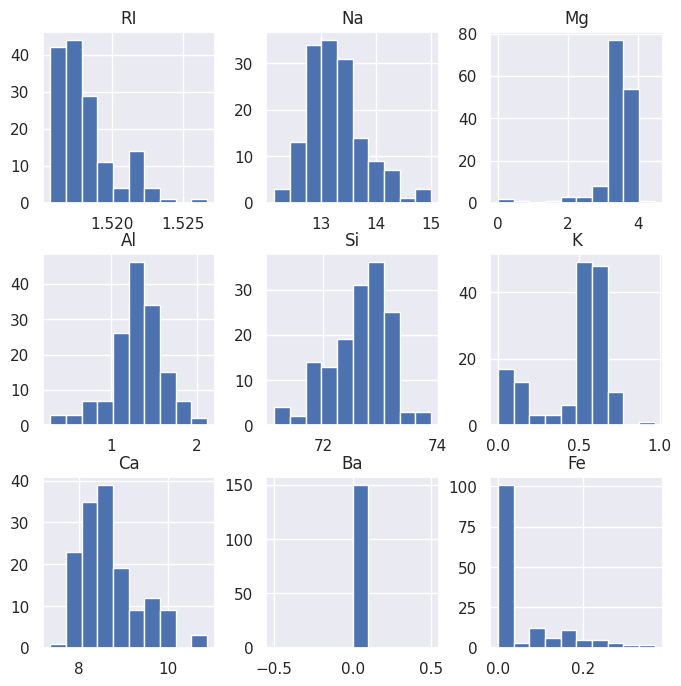

In [15]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
clean_df.drop(columns="Type").hist(ax=axs)
plt.show()

In [16]:
X = clean_df[['RI', 'Na', 'Mg', 'Al', 'Si', 'Ca', 'Ba']]
y = clean_df["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
rf_clf = make_pipeline( 
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=100,
        criterion="entropy",
        max_depth=5,
        min_samples_split=30,
        min_samples_leaf=10,
        max_features=3,
        max_samples=0.63,
        random_state=0
    )
)       
rf_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=5,
                                        max_features=3, max_samples=0.63,
                                        min_samples_leaf=10,
                                        min_samples_split=30,
                                        random_state=0))])

In [18]:
y_pred = rf_clf.predict(X_test)
print(f"Score: {rf_clf.score(X_test, y_test)}")
print(f"Accuracy: {accuracy_score(y_pred, y_test)}")

Score: 0.8666666666666667
Accuracy: 0.8666666666666667


### Выводы
1. В 2-х случаях данные стандартизировались. Во втором случае были удаленны выбросы из некоторых признаков.
2. Сравнение моделей:

    |№| Model        | Accuracy | Score | Features                   |
    |-|--------------|----------|-------|----------------------------|
    |1| RandomForest |   0.866  | 0.866 | RI, Na, Mg, Al, Si, Ca, Ba |
    |2| RandomForest |   0.511  | 0.511 | RI, Na, Mg, Al, Si, Ca, Ba |
    
3. Любая DS задача нуждается и начинается с EDA. Особенно нужно уделить внимание на выбросы. В данной задаче можно было достигнуть ещё более лучшего распределения, но к сожалению в задаче слишком мало записей, и не мало признаков, и лучший выд не приведет к улучшению качества модели, поэтому нужно искать компромисс.